# Large Language Models

In [1]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

In [2]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tools.text import process_text, generate_sequences, total_params

In [6]:
# here you can set which device to use
device = 'cuda' # 'cpu'

## Simple Markov Model

First let's look at a (comparatively) simple Markov-style model in which do next token prediction. I'm going train it on only book, that classic outlier Moby Dick.

In [7]:
with open('data/moby_dick.txt') as fid:
    moby = fid.read()
moby1 = process_text(moby)

In [8]:
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(moby1)
print(len(tokens))
print(' | '.join(tokens[92:180]))

257442
hand | to | school | others | , | and | to | teach | them | by | what | name | a | whale | fish | is | to | be | called | in | our | tongue | leaving | out | , | through | ignorance | , | the | letter | h | , | which | almost | alone | maketh | the | signification | of | the | word | , | you | deliver | that | which | is | not | true | . | , | hackluyt | whale | . | . | . | . | sw | . | and | dan | . | hval | . | this | animal | is | named | from | roundness | or | rolling | , | for | in | dan | . | hvalt | is | arched | or | vaulted | . | , | webster | ' | s | dictionary


In [9]:
vocab = build_vocab_from_iterator([tokens], specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
indices = vocab(tokens)
print(len(vocab))
print(indices[:91])

17167
[290, 288, 27, 12790, 13799, 5119, 12011, 3, 139, 1812, 27, 6, 719, 11156, 9450, 7, 6, 7859, 2144, 140, 2, 1102, 9450, 1, 16218, 8, 762, 1, 263, 1, 234, 1, 5, 580, 1, 13, 108, 30, 38, 3, 14, 21, 145, 7552, 11, 69, 13525, 5, 7860, 1, 20, 6, 506, 3806, 1, 13900, 5586, 20, 23, 2, 994, 12266, 4, 23, 2, 301, 1766, 4, 2, 164, 3, 14, 5966, 7, 2062, 11, 69, 7860, 1, 12, 507, 2110, 4862, 30, 4, 11, 13948, 3, 121, 36, 195]


In [10]:
class MarkovLanguage(nn.Module):
    def __init__(self, window_len, vocab_size, embed_dim, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.flatten = nn.Flatten()
        self.dropout0 = nn.Dropout(dropout)
        self.linear0 = nn.Linear(window_len*embed_dim, embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(embed_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear0.weight.data.uniform_(-initrange, initrange)
        self.linear0.bias.data.zero_()
        self.linear1.weight.data.uniform_(-initrange, initrange)
        self.linear1.bias.data.zero_()

    def forward(self, toks):
        x = self.embedding(toks)
        x = self.dropout0(x)
        x = self.flatten(x)
        x = F.relu(self.linear0(x))
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

In [11]:
def language_model(model, train_data, valid_data, lr=0.01, shuffle=False, epochs=10, batch_size=1000):
    # make data loader
    train_load = torch.utils.data.DataLoader(train_data, shuffle=shuffle, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.RMSprop(model.parameters(), lr=lr)

    # define loss function
    bce_loss = nn.CrossEntropyLoss()

    # track history
    history = []

    # go for many iterations
    for i in tqdm(range(epochs)):
        n_batch = 0
        train_stats = 0.0
        
        # iterate over batches
        model.train()
        for batch_x, batch_y in train_load:
            # compute loss
            logits = model(batch_x)
            loss = bce_loss(logits, batch_y)

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += loss.detach().item()

        # average training
        train_stats /= n_batch

        # validation stats
        model.eval()
        valid_logits = model(valid_x)
        valid_loss = bce_loss(valid_logits, valid_y)
        valid_stats = valid_loss.detach().item()

        # make it a mean
        stats = torch.tensor([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_loss', 'valid_loss']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

In [12]:
V_moby = len(vocab) # vocabulary size
W_moby = 64 # sequence window size
E_moby = 32 # embedding size
M_moby = 2000 # validation set size

In [13]:
# make full dataset
seqs, targ = generate_sequences(torch.tensor(indices).reshape(1, -1), W_moby)
moby_data = torch.utils.data.TensorDataset(seqs.to(device), targ.to(device))
train_split, valid_split = torch.utils.data.random_split(moby_data, [len(moby_data)-M_moby, M_moby])
moby_train = torch.utils.data.TensorDataset(*moby_data[train_split.indices])
moby_valid = torch.utils.data.TensorDataset(*moby_data[valid_split.indices])

1181423


100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]


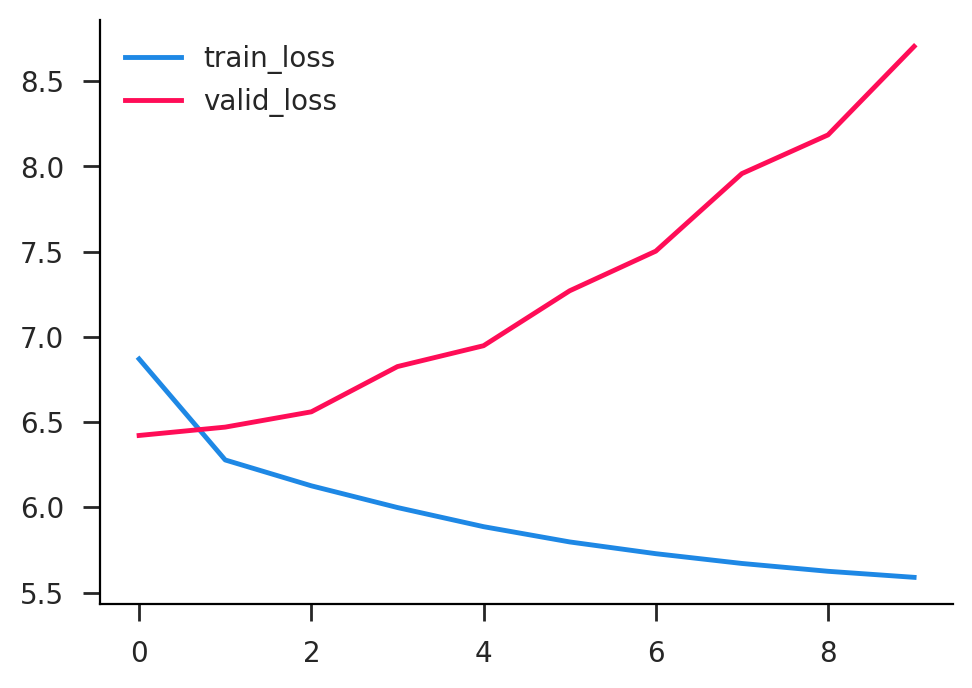

In [14]:
# create model (it's a big one)
lmod = MarkovLanguage(W_moby, V_moby, E_moby).to(device)
print(sum([p.numel() for p in lmod.parameters()]))
hist = language_model(lmod, moby_train, moby_valid, epochs=10)
hist.plot();

100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


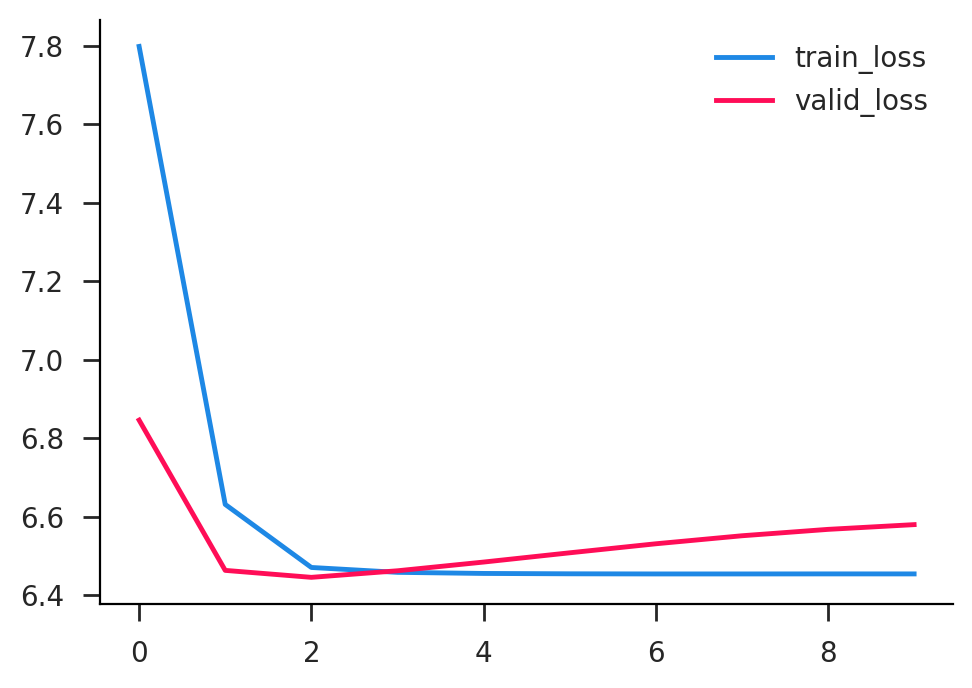

In [15]:
# create model (with dropout)
lmod_drop = MarkovLanguage(W_moby, V_moby, E_moby, dropout=0.5).to(device)
hist_drop = language_model(lmod_drop, moby_train, moby_valid, epochs=10)
hist_drop.plot();

In [16]:
lmtoks = vocab.get_itos()
def pad_list(x, n, v=0):
    return x[-n:] + [0]*max(0, n-len(x))
def sample_word(logits, temp=1.0):
    probs = (logits/temp).exp()
    word = probs.multinomial(1)
    return word.squeeze().item()
def predict_next(model, prompt, temp=1.0):
    toks = prompt.split()
    index = pad_list(vocab(toks), W_moby)
    vecs = torch.tensor(index, device=device).unsqueeze(0)
    pred = model(vecs).squeeze(0)
    word = sample_word(pred, temp=temp)
    return lmtoks[word]
def predict_many(model, prompt, n, temp=1.0):
    prompt = f'{prompt}\n\n██\n\n'
    for i in range(n):
        word = predict_next(model, prompt, temp=temp)
        prompt = f'{prompt} {word}'
    return prompt

In [17]:
output = predict_many(lmod, moby1[35000:36000], 250, temp=1.0)
print(output.replace('\\n', '\n\n'))

ll the following monday .
as most young candidates for the pains and penalties of whaling stop at this same new bedford , thence to embark on their voyage , it may as well be related that i , for one , had no idea of so doing . for my mind was made up to sail in no other than a nantucket craft , because there was a fine , boisterous something about everything connected with that famous old island , which amazingly pleased me . besides though new bedford has of late been gradually monopolising the business of whaling , and though in this matter poor old nantucket is now much behind her , yet nantucket was her great original , the tyre of this carthage , , the place where the first dead american whale was stranded . where else but from nantucket did those aboriginal whalemen , the red men , first sally out in canoes to give chase to the leviathan ? and where but from nantucket , too , did that first adventurous little sloop put forth , partly laden with imported cobblestones , so goes th

## Attention

Let's look at the total number of parameters in the model.

In [18]:
total_params(lmod)

1181423

One issue with the above model is that it's kind of too wide. We do a linear map from `window_len*embed_dim` down to `embed_dim` and then do next word prediction. It would be better to add more layers, but if we do so without making each layer thinner, we risk being way overparameterized. As it is, we only have 260k tokens in our training set. We want a way for there to be interaction terms between different word positions. Doing the full dense interaction would require a `window_len^2 * embed_dim^2 = 6.25e6` element matrix.

Instead we'll use what's called an attention mechanism, which is perhaps the most important element in any transformer model. This will allow for some (but not arbitrary) interactions between different window positions, and it only requires `3 * embed_dim^2` parameters. Then with this savings, we can stack up a few more layers and still be way better off in terms of total parameter count.

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
    def forward(self, x):
        q, k, v = self.q(x), self.k(x), self.v(x) # (B,T,E) => (B,T,E)
        w = q @ k.transpose(-2, -1) # (B,T,E) x (B,T,E) => (B,T,T)
        a = F.softmax(w / math.sqrt(self.dim), dim=-1) # (B,T,T) => (B,T,T)
        y = a @ v # (B,T,T) x (B,T,E) => (B,T,E)
        return y

Essentially what's going on here is we're computing query $Q$, key $K$, and value $V$ as functions of our data. The matrix $A = \text{softmax}(Q \times K)$ is of shape `(T,T)` and tells us where each position should be looking. We then compute $A \times V$ to generate a final weighted output, which in this case is the same shape as our input. Let's create the layer and see what it looks like.

In [20]:
att = SelfAttention(E_moby).to(device)
print(total_params(att))
att

3168


SelfAttention(
  (q): Linear(in_features=32, out_features=32, bias=True)
  (k): Linear(in_features=32, out_features=32, bias=True)
  (v): Linear(in_features=32, out_features=32, bias=True)
)

Now we can just call it directly on the embedding output from our previous model.

In [21]:
test_emb = lmod.embedding(seqs[0,:].to(device))
test_att = att(test_emb)
test_att.shape

torch.Size([64, 32])

## Transformers